# Analyze models
##### authors: Elizabeth A. Barnes and Noah Diffenbaugh
##### date: March 20, 2022


## Python stuff

In [1]:
import sys, os, copy
import importlib as imp

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
import tensorflow_probability as tfp

import scipy.stats as stats
import seaborn as sns

import experiment_settings
import file_methods, plots, data_processing

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")  
print(f"tensorflow version = {tf.__version__}")  
print(f"tensorflow-probability version = {tfp.__version__}")  

python version = 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) 
[Clang 13.0.1 ]
numpy version = 1.19.5
xarray version = 2022.6.0
tensorflow version = 2.7.0
tensorflow-probability version = 0.15.0


## User Choices

In [3]:
# EXP_NAME = 'exp15C_126_nohigh7'  
EXP_NAME = 'exp15C_126_smooth_nohigh7'
#-------------------------------------------------------

settings = experiment_settings.get_settings(EXP_NAME)
# display(settings)

MODEL_DIRECTORY = 'saved_models/'        
PREDICTIONS_DIRECTORY = 'saved_predictions/'
DATA_DIRECTORY = 'data/'
DIAGNOSTICS_DIRECTORY = 'model_diagnostics/'
FIGURE_DIRECTORY = 'figures/'

## Get seed to show in plot
You need to first run compare_random_seeds.ipynb to ensure the data/stats on your experiments were saved in the df_random_seed.pickle file.

In [4]:
df_metrics = pd.read_pickle(PREDICTIONS_DIRECTORY + "df_random_seed_rev2.pickle")
df = df_metrics[df_metrics["exp_name"]==EXP_NAME]
PLOT_SEED = df_metrics.iloc[df['loss_val'].idxmin()]["seed"]
PLOT_SEED = 2247
print(PLOT_SEED)
display(df)

2247


,exp_name,seed,hiddens,ridge_param,error_val,error_test,loss_val,loss_test,d_val,d_test,d_valtest,best_2021_mu,best_2021_sigma,giss_2021_mu,giss_2021_sigma
493,exp15C_126_smooth_nohigh7,1257,"[25, 25]",10.0,7.888540,7.816106,3.766665,3.820689,0.015276,0.019691,0.011756,17.577095,14.720168,23.865356,14.143657
494,exp15C_126_smooth_nohigh7,5322,"[25, 25]",10.0,8.293999,7.850680,3.871216,3.811612,0.015788,0.016568,0.015006,17.664040,16.694164,22.633184,16.111324
495,exp15C_126_smooth_nohigh7,2247,"[25, 25]",10.0,7.720732,8.529997,3.729657,3.811094,0.013949,0.023272,0.016186,15.399868,13.667131,21.634546,12.482459


## Get observations

In [5]:
## determine how many GCMs are being used
filenames = file_methods.get_cmip_filenames(settings, verbose=0)
N_GCMS = len(filenames)

# get CMIP6 info
N_TRAIN, N_VAL, N_TEST, ALL_MEMBERS = data_processing.get_members(settings)

# load BEST observations for diagnostics plotting
da_obs, x_obs, global_mean_obs = data_processing.get_observations(DATA_DIRECTORY, settings)

# load GISS observations
settings["obsdata"] = 'GISS'
da_obs_giss, x_obs_giss, global_mean_obs_giss = data_processing.get_observations(DATA_DIRECTORY, settings)


observations: filling NaNs with zeros
np.shape(x_obs) = (172, 10368)
observations: filling NaNs with zeros
np.shape(x_obs) = (142, 10368)


## Plotting Functions

In [6]:
FS = 10

### for white background...
# plt.rc('text',usetex=True)
plt.rc('text',usetex=False)
# plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([]) 

def format_spines(ax):
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
#     ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)    
    

## Load the observations predictions

In [7]:
rng = np.random.default_rng(settings["rng_seed"])
pred_obs_vec = np.zeros(shape=(settings['n_models'], x_obs.shape[0], 2))*np.nan

for iloop in np.arange(settings['n_models']):
    seed = rng.integers(low=1_000,high=10_000,size=1)[0]
    settings["seed"] = int(seed)

    # get model name
    model_name = file_methods.get_model_name(settings)
    filename = PREDICTIONS_DIRECTORY+model_name + '_obs_predictions.pickle'
    if os.path.exists(filename):
        obs_pred_seed = pd.read_pickle(filename)
        pred_obs_vec[iloop,:,0] = obs_pred_seed[:,0] 
        pred_obs_vec[iloop,:,1] = obs_pred_seed[:,1] 
    else:
        print(model_name  +" does not exist. Skipping...") 
        print("================================\n")
        continue    
        #----------------------------------------
        
    if seed == PLOT_SEED:
        print(filename)
        obs_pred_plot = copy.deepcopy(obs_pred_seed)
        model_name_plot = copy.deepcopy(model_name)

print("done.")

saved_predictions/exp15C_126_smooth_nohigh7_seed2247_obs_predictions.pickle
done.


## Plot spread in $\mu$ across random seeds

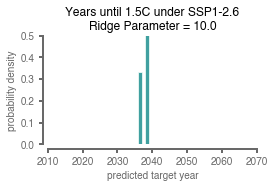

In [8]:
INPUT_YEAR = 2021
iyear = np.where(da_obs["time.year"]==INPUT_YEAR)[0]

perc_low = np.percentile(pred_obs_vec[:,iyear,0],25)
perc_high = np.percentile(pred_obs_vec[:,iyear,0],25)

i = np.where(pred_obs_vec==0)[0]
pred_obs_vec[i] = np.nan

plt.figure(figsize=(3.75,2.))
plt.hist(INPUT_YEAR+pred_obs_vec[:,iyear,0],
         bins=np.arange(1850,2100),
         color="teal",
         width=.925,
         edgecolor='mintcream',
         alpha=.75,
         density=True,
        )


plt.xticks(np.arange(-101,100,10)+2021,np.arange(-101,100,10)+2021)
plt.yticks(np.arange(0,1.2,.1),np.arange(0,1.2,.1).round(1))
plt.xlim(2010,2070)
plt.ylim(0,.5)
plt.xlabel('predicted target year',fontsize=FS)
plt.ylabel('probability density',fontsize=FS)

ax = plt.gca()
format_spines(ax)

plt.title('Years until ' + str(settings["target_temp"]) + 'C under SSP' + settings["ssp"][0] + '-' + settings["ssp"][1] + '.' + settings["ssp"][-1] + '\nRidge Parameter = ' + str(settings["ridge_param"][0]),
          color='k',
          fontsize=FS*1.2,
         )
plots.savefig(FIGURE_DIRECTORY + settings["exp_name"] + '_spread_mu', dpi=savefig_dpi)
plt.show()

## Plot Single Seed Obs

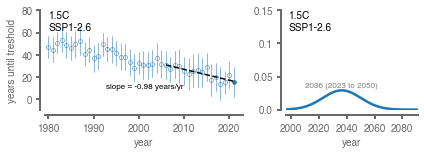

In [9]:
if settings["ssp"]=='370':
    clr_choice = 'tab:red'
elif settings["ssp"]=='245':
    clr_choice = 'tab:purple'
else:
    clr_choice = 'tab:blue'
    
y_predict_obs = obs_pred_plot

iy = np.where(da_obs['time.year'].values >= 2021-15)[0]
x = da_obs['time.year'].values[iy]
y = y_predict_obs[iy,0]
linear_model = stats.linregress(x=x,y=y)

#--------------------------------
norm_incs = np.arange(-80,80,1)
mu_pred = y_predict_obs[:,0]
sigma_pred = y_predict_obs[:,1]
norm_dist = tfp.distributions.Normal(mu_pred,sigma_pred)
# norm_perc_low = norm_dist.quantile(.25).numpy()   
# norm_perc_high = norm_dist.quantile(.75).numpy()      
norm_perc_med = norm_dist.quantile(.5).numpy()      
norm_cpd = norm_dist[-1].prob(norm_incs)
y_predict_obs = norm_perc_med

pred_text = (str(int(mu_pred[-1].round(0)+2021)) + 
             ' (' + str(int((mu_pred[-1]-sigma_pred[-1]).round(0)+2021)) + 
             ' to ' + str(int((mu_pred[-1]+sigma_pred[-1]).round(0)+2021)) + 
             ')'
            )

#------------------------------------------------------------
ax = plt.subplots(1,2,figsize=(6,2.25),gridspec_kw={'width_ratios': [3, 2]})
years = np.arange(1850,2022)

plt.subplot(1,2,1)
for iyear in np.arange(0,y_predict_obs.shape[0]):
    if(years[iyear]<1980):
        continue
    min_val = mu_pred[iyear]-sigma_pred[iyear]
    med_val = mu_pred[iyear]
    max_val = mu_pred[iyear]+sigma_pred[iyear]

    # clr = 'lightseagreen'
    if(years[iyear]==2021):
        clr = clr_choice
        facecolor = clr
    else:
        clr = clr_choice#'dimgrey'
        facecolor = 'w'
    
    plt.plot(years[iyear],
             med_val,
             'o',
             markersize=4,
             color=clr,
             markeredgewidth=.5,
             markerfacecolor=facecolor,
            )
    # comment out the plotting line below if you don't want 
    # error bars
    plt.plot((years[iyear],years[iyear]),(min_val, max_val),
             linestyle='-',
             linewidth=.5,
             color=clr,
            )

plt.plot(x,x*linear_model.slope+linear_model.intercept,'--', color='black')
plt.text(2010,
         norm_perc_med[-1]*.5,
         'slope = ' + str(linear_model.slope.round(2)) + ' years/yr',         
         horizontalalignment="right",
         verticalalignment="bottom",
         color='k',
         fontsize=FS*0.8,
        )

plt.xticks(np.arange(1850,2100,10),np.arange(1850,2100,10))
plt.yticks(np.arange(-100,100,20),np.arange(-100,100,20).round(0))
plt.ylabel('years until treshold')
plt.xlabel('year')

plt.text(1980,
         80,
         str(settings["target_temp"]) + "C\nSSP" + settings["ssp"][0] + '-' + settings["ssp"][1] + '.' + settings["ssp"][-1],
         fontsize=FS,
         horizontalalignment="left",
         verticalalignment="top",
         color='k', 
         # weight="bold",
        )

plt.xlim(1979.25,2023)    
plt.ylim(-10,80)
format_spines(plt.gca())

#---------------------------------------------------------------
# plot PDF

plt.subplot(1,2,2)
plt.plot(norm_incs+2021,
         norm_cpd,
         linewidth=2.5,
         color=clr_choice,
        )
         

# k = np.argmin(np.abs((mu_pred[-1]-sigma_pred[-1])-norm_incs))
# k = np.argmin(np.abs((mu_pred[-1]+sigma_pred[-1])-norm_incs))

plt.text(mu_pred[-1]+2021,
         np.max(norm_cpd)*1.05,
         pred_text,         
         horizontalalignment="center",
         verticalalignment="bottom",
         color='gray',
         fontsize=FS*0.8,
        )
if(settings["target_temp"]==1.1):
    plt.text((mu_pred[-1]-sigma_pred[-1])+2021+22.5,
             np.max(norm_cpd)*0.35,
             '2021',
             fontsize=FS,
             horizontalalignment="left",
             verticalalignment="bottom",
             color=clr_choice, 
             weight="bold",
            )

plt.text(1998,
         .15,
         str(settings["target_temp"]) + "C\nSSP" + settings["ssp"][0] + '-' + settings["ssp"][1] + '.' + settings["ssp"][-1],
         fontsize=FS,
         horizontalalignment="left",
         verticalalignment="top",
         color='k', 
         # weight="bold",
        )
         
plt.xlabel('year')
# plt.title('Predictions for ' + settings["obsdata"] + ' Observations under SSP' + settings["ssp"] + '\nYear = 2021')
plt.xticks(np.arange(-101,100,20)+2021,np.arange(-101,100,20)+2021)
plt.yticks(np.arange(0,.25,.05),np.arange(0,.25,.05).round(2))
# plt.yticks([])

plt.xlim(-25+2021,70+2021)
plt.ylim(-0.001,.15)
format_spines(plt.gca())
# plt.gca().spines['left'].set_color(None)

plt.tight_layout()
plots.savefig(FIGURE_DIRECTORY + model_name_plot + '_obs_timeseries_spread', dpi=savefig_dpi)
plt.show()

** grabbing smoothed simulations **


,exp_name,seed,hiddens,ridge_param,error_val,error_test,loss_val,loss_test,d_val,d_test,d_valtest,best_2021_mu,best_2021_sigma,giss_2021_mu,giss_2021_sigma
412,exp15C_126,2247,"[25, 25]",10.0,6.628896,7.140835,3.556717,3.571278,0.023518,0.023357,0.022511,12.400796,7.72959,18.702929,9.012171


,exp_name,seed,hiddens,ridge_param,error_val,error_test,loss_val,loss_test,d_val,d_test,d_valtest,best_2021_mu,best_2021_sigma,giss_2021_mu,giss_2021_sigma
492,exp15C_126_smooth_nohigh10,2247,"[25, 25]",10.0,7.890357,8.628008,3.741841,3.844921,0.011461,0.021897,0.014288,12.279219,12.487317,16.725784,12.590515


,exp_name,seed,hiddens,ridge_param,error_val,error_test,loss_val,loss_test,d_val,d_test,d_valtest,best_2021_mu,best_2021_sigma,giss_2021_mu,giss_2021_sigma
495,exp15C_126_smooth_nohigh7,2247,"[25, 25]",10.0,7.720732,8.529997,3.729657,3.811094,0.013949,0.023272,0.016186,15.399868,13.667131,21.634546,12.482459


,exp_name,seed,hiddens,ridge_param,error_val,error_test,loss_val,loss_test,d_val,d_test,d_valtest,best_2021_mu,best_2021_sigma,giss_2021_mu,giss_2021_sigma
498,exp15C_126_smooth_nohigh5,2247,"[25, 25]",10.0,7.967566,8.92169,3.844151,4.022543,0.027381,0.049397,0.034739,15.317514,13.702241,25.159822,12.534656


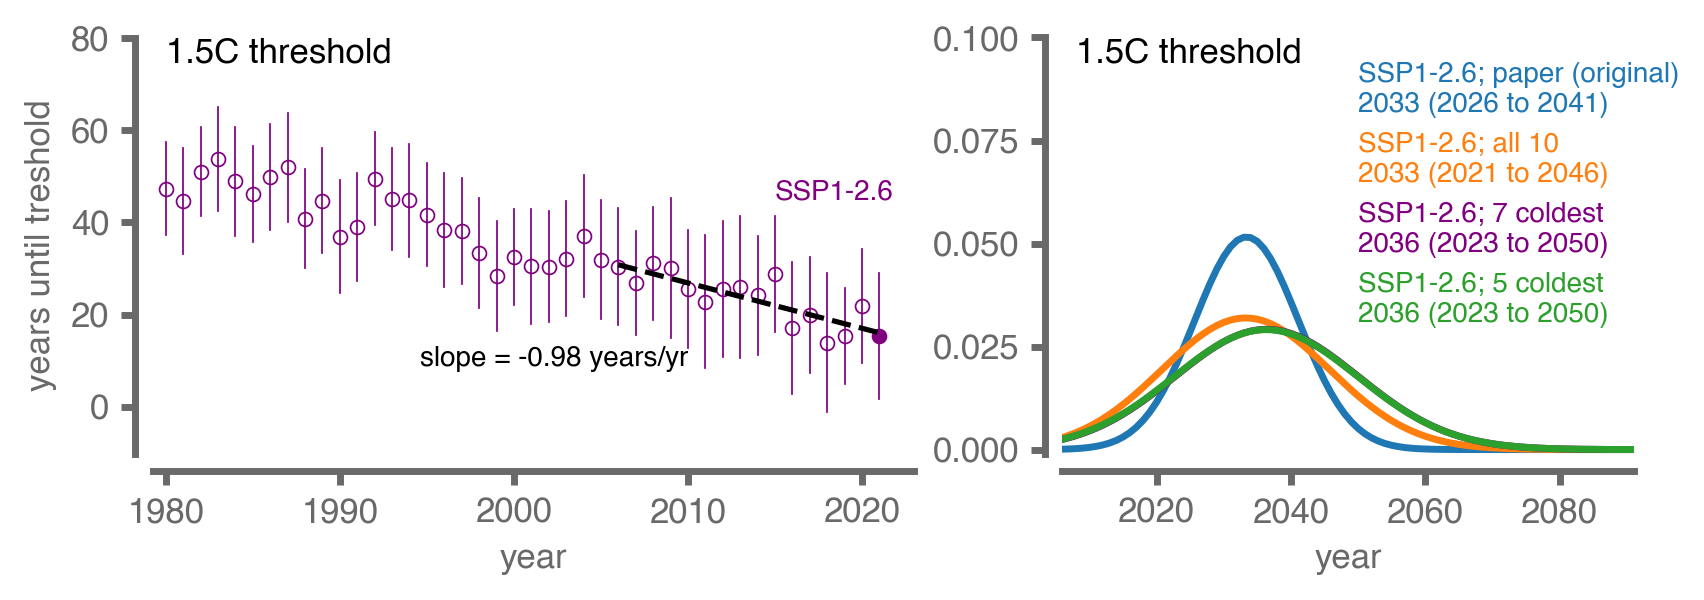

In [15]:
if settings["ssp"]=='370':
    clr_choice = 'tab:red'
    ssp_text = 'SSP3-7.0'
elif settings["ssp"]=='245':
    clr_choice = 'tab:purple'
    ssp_text = 'SSP2-4.5'    
else:
    clr_choice = 'purple'
    ssp_text = 'SSP1-2.6'    
    
y_predict_obs = obs_pred_plot

iy = np.where(da_obs['time.year'].values >= 2021-15)[0]
x = da_obs['time.year'].values[iy]
y = y_predict_obs[iy,0]
linear_model = stats.linregress(x=x,y=y)

#--------------------------------
norm_incs = np.arange(-80,80,1)
mu_pred = y_predict_obs[:,0]
sigma_pred = y_predict_obs[:,1]
norm_dist = tfp.distributions.Normal(mu_pred,sigma_pred)
# norm_perc_low = norm_dist.quantile(.25).numpy()   
# norm_perc_high = norm_dist.quantile(.75).numpy()      
norm_perc_med = norm_dist.quantile(.5).numpy()      
norm_cpd = norm_dist[-1].prob(norm_incs)
y_predict_obs = norm_perc_med

pred_text = (str(int(mu_pred[-1].round(0)+2021)) + 
             ' (' + str(int((mu_pred[-1]-sigma_pred[-1]).round(0)+2021)) + 
             ' to ' + str(int((mu_pred[-1]+sigma_pred[-1]).round(0)+2021)) + 
             ')'
            )

#------------------------------------------------------------
axs = plt.subplots(1,2,figsize=(7,2.5),gridspec_kw={'width_ratios': [4, 3]}, dpi=250)
years = np.arange(1850,2022)

plt.subplot(1,2,1)
for iyear in np.arange(0,y_predict_obs.shape[0]):
    if(years[iyear]<1980):
        continue
    min_val = mu_pred[iyear]-sigma_pred[iyear]
    med_val = mu_pred[iyear]
    max_val = mu_pred[iyear]+sigma_pred[iyear]

    # clr = 'lightseagreen'
    if(years[iyear]==2021):
        clr = clr_choice
        facecolor = clr
    else:
        clr = clr_choice#'dimgrey'
        facecolor = 'w'
    
    plt.plot(years[iyear],
             med_val,
             'o',
             markersize=4,
             color=clr,
             markeredgewidth=.5,
             markerfacecolor=facecolor,
            )
    # comment out the plotting line below if you don't want 
    # error bars
    plt.plot((years[iyear],years[iyear]),(min_val, max_val),
             linestyle='-',
             linewidth=.5,
             color=clr,
            )

plt.plot(x,x*linear_model.slope+linear_model.intercept,'--', color='black')
plt.text(2010,
         norm_perc_med[-1]*.5,
         'slope = ' + str(linear_model.slope.round(2)) + ' years/yr',         
         horizontalalignment="right",
         verticalalignment="bottom",
         color='k',
         fontsize=FS*0.8,
        )

plt.xticks(np.arange(1850,2100,10),np.arange(1850,2100,10))
plt.yticks(np.arange(-100,100,20),np.arange(-100,100,20).round(0))
plt.ylabel('years until treshold')
plt.xlabel('year')

plt.text(1980,
         80,
         str(settings["target_temp"]) + 'C threshold',
         fontsize=FS,
         horizontalalignment="left",
         verticalalignment="top",
         color='k', 
         # weight="bold",
        )   
plt.text(2015,
         45,
         ssp_text,
         fontsize=8,
         color=clr_choice,
         horizontalalignment='left',
        )


plt.xlim(1979.25,2023)    
plt.ylim(-10,80)
format_spines(plt.gca())

###############################
norm_incs = np.arange(-80,80,1)
#------------------------------------------------------------
plt.subplot(1,2,2)

PLOT_SEED = 2247
obs_type = 'best'
thresh = settings["target_temp"]

if EXP_NAME.find('smooth')>0:
    print('** grabbing smoothed simulations **')
    EXP_FOR_PLOTTING = ('exp15C_126','exp15C_126_smooth_nohigh10','exp15C_126_smooth_nohigh7','exp15C_126_smooth_nohigh5')        
else:
    EXP_FOR_PLOTTING = ('exp15C_126','exp15C_126_nohigh10','exp15C_126_nohigh7','exp15C_126_nohigh5')
    
# EXP_FOR_PLOTTING = ('exp15C_126_smooth_nohigh','exp15C_126_smooth_nohigh5')        
thresh_text = '1.5C'        
text_x = 2050        

for iexp,exp_name in enumerate(EXP_FOR_PLOTTING):
    iplot = np.where((df_metrics["exp_name"]==exp_name) & (df_metrics["seed"]==PLOT_SEED))[0]

    display(df_metrics.iloc[iplot])

    mu_pred = df_metrics.iloc[iplot][obs_type + "_2021_mu"].values[0]
    sigma_pred = df_metrics.iloc[iplot][obs_type + "_2021_sigma"].values[0]
    norm_dist = tfp.distributions.Normal(mu_pred,sigma_pred)
    norm_perc_low = norm_dist.quantile(.25).numpy()   
    norm_perc_high = norm_dist.quantile(.75).numpy()      
    norm_perc_med = norm_dist.quantile(.5).numpy()      
    norm_cpd = norm_dist.prob(norm_incs)

    if(exp_name=='exp15C_126'):
        clr = "tab:blue"
        # text_x = 2040
        text_y = .08+.002
        ssp_text = 'SSP1-2.6; paper (original)'
        
    elif(exp_name=='exp15C_126_smooth_nohigh10' or exp_name=='exp15C_126_nohigh10'):
        clr = "tab:orange"
        # text_x = 2050
        text_y = .065        
        ssp_text = 'SSP1-2.6; all 10'

    elif(exp_name=='exp15C_126_smooth_nohigh7' or exp_name=='exp15C_126_nohigh7'):
        clr = "purple"
        # text_x = 2050
        text_y = .05-.002            
        ssp_text = 'SSP1-2.6; 7 coldest'
        
    elif(exp_name=='exp15C_126_smooth_nohigh5' or exp_name=='exp15C_126_nohigh5'):
        clr = "tab:green"
        # text_x = 2070
        text_y = .05-.004-.015    
        ssp_text = 'SSP1-2.6; 5 coldest'
    else:
        raise ValueError('no such exp')    
        
    plt.plot(norm_incs+2021,
             norm_cpd,
             color=clr,
             linewidth=2.,
            )

    # plot the text above the bars
    text_name = ssp_text + '\n' + str(int(np.round(mu_pred+2021))) + ' (' + str(int(np.round(mu_pred+2021-sigma_pred))) + ' to ' + str(int(np.round(mu_pred+2021+sigma_pred))) + ')'
    plt.text(text_x,
             text_y,
             text_name,
             fontsize=8,
             color=clr,
             horizontalalignment='left',
            )
plt.text(1998+10,
         .1,
         thresh_text + ' threshold',
         fontsize=FS,
         horizontalalignment="left",
         verticalalignment="top",
         color='k', 
         # weight="bold",
        )    

plt.xlabel('year')
format_spines(plt.gca())
plt.xlim(-15+2021,70+2021)
plt.ylim(-0.001,.1)

plt.tight_layout()
plots.savefig(FIGURE_DIRECTORY + model_name_plot + '_obs_2021PDF_allSSPs',dpi=savefig_dpi)
plt.show()


## Analyze CMIP results

In [11]:
rng = np.random.default_rng(settings["rng_seed"])
settings["seed"] = PLOT_SEED

# get model name
model_name = file_methods.get_model_name(settings)

# load the model
model = file_methods.load_tf_model(model_name, MODEL_DIRECTORY)

# get the data
(x_train, 
 x_val, 
 x_test, 
 y_train, 
 y_val, 
 y_test, 
 onehot_train, 
 onehot_val, 
 onehot_test, 
 y_yrs_train, 
 y_yrs_val, 
 y_yrs_test, 
 target_years, 
 map_shape,
 settings) = data_processing.get_cmip_data(DATA_DIRECTORY, settings)


[4 0 2] [1] [3]
tas_Amon_historical_ssp126_MIROC6_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2069, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_MIROC-ES2L_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2042, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_MRI-ESM2-0_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2031, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_ACCESS-ESM1-5_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2031, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_CNRM-CM6-1_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2026, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_CNRM-ESM2-1_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2037, TARGET_TEMP = 1.5
tas_Amon_historical_ssp126_GISS-E2-1-G_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2030, TARGET_TEMP = 1.5
---------------------------
data_train.shape = (21, 131, 72, 144)
data_val.shape = (7, 131, 72, 144)
data_test.shape = (7, 131, 72, 144)
(2751, 10368) (2751,) (2751,)
(917, 10368) (917,) (917,)
(917, 103

2022-11-02 06:08:43.680491: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


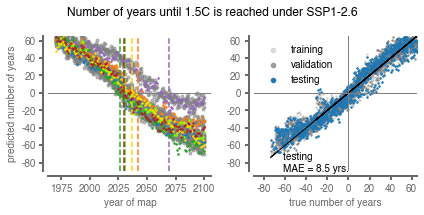

In [12]:
top_pred_idx = 0

YEARS_UNIQUE = np.unique(y_yrs_train)
predict_train = model.predict(x_train)[:,top_pred_idx].flatten()
predict_val = model.predict(x_val)[:,top_pred_idx].flatten()
predict_test = model.predict(x_test)[:,top_pred_idx].flatten()
mae = np.mean(np.abs(predict_test-y_test[:]))

#--------------------------------
clr = ('tab:purple','tab:orange', 'tab:blue', 'tab:green', 'gold', 'brown','black','darkorange','fuchsia','lawngreen')
if settings["ssp"]=="245":
    clr = ('tab:purple','tab:orange', 'fuchsia', 'tab:green', 'gold', 'brown','black','darkorange','fuchsia','lawngreen')
elif settings["ssp"]=="126":
    clr = ('tab:purple','tab:orange', 'tab:blue', 'lawngreen','tab:green', 'gold', 'brown','black','darkorange','fuchsia','lawngreen')

plt.subplots(1,2,figsize=(6,3))

plt.subplot(1,2,1)
plt.plot(y_yrs_train, predict_train,'.',color='gray',alpha=.5, label='training')
# plt.title('Time to Target Year for ' + str(settings['target_temp']) + 'C using ssp' + str(settings['ssp']))
plt.xlabel('year of map',fontsize=FS)
plt.ylabel('predicted number of years',fontsize=FS)
plt.yticks(np.arange(-80,100,20),np.arange(-80,100,20))
plt.xticks(np.arange(1900,2120,25),np.arange(1900,2120,25))
plt.ylim(-90,65)
plt.axhline(y=0, color='gray', linewidth=1)
format_spines(plt.gca())



predict_val_mat = predict_val.reshape(N_GCMS,N_VAL,len(YEARS_UNIQUE))
for i in np.arange(0,predict_val_mat.shape[0]):
    plt.plot(YEARS_UNIQUE, predict_val_mat[i,:,:].swapaxes(1,0),
             '.', 
             markersize=3,
             label='validation', color=clr[i])
    plt.axvline(x=target_years[i],linestyle='--',color=clr[i])

    
    
plt.subplot(1,2,2)
plt.plot(y_train, predict_train,'.',color='gray',alpha=.25, label='training',markersize=3,)
plt.plot(y_val, predict_val,'.', label='validation',color='gray',alpha=.75,markersize=3,)
plt.plot(y_test, predict_test,'.', label='testing',markersize=3)    
plt.plot(y_train,y_train,'-',color='k',linewidth=1)
plt.axvline(x=0,color='gray',linewidth=1)
plt.axhline(y=0,color='gray',linewidth=1)
# plt.title('Testing MAE = ' + str(mae.round(2)) + ' years')
plt.xlabel('true number of years',fontsize=FS)
plt.ylabel(None)
plt.legend(fontsize=FS,frameon=False,markerscale=3.,loc=2)

plt.xticks(np.arange(-80,100,20),np.arange(-80,100,20))
plt.yticks(np.arange(-80,100,20),np.arange(-80,100,20))
plt.xlim(-90,65)
plt.ylim(-90,65)

plt.text(-62.5,
         -80,
         'testing \nMAE = ' + str(mae.round(1)) + ' yrs.',
         fontsize=FS,
         horizontalalignment="left",
         verticalalignment="center",
         color='k', 
         # weight="bold",
        )


plt.suptitle('Number of years until ' + str(settings["target_temp"]) + 'C' + ' is reached under SSP' + str(settings["ssp"][0]) + '-' + str(settings["ssp"][1]) + '.' + str(settings["ssp"][2]),fontsize=FS*1.2)
format_spines(plt.gca())

plt.tight_layout()
plots.savefig(FIGURE_DIRECTORY + model_name_plot + '_cmip_validation_scatter', dpi=savefig_dpi)
plt.show()


### Plot PIT histogram

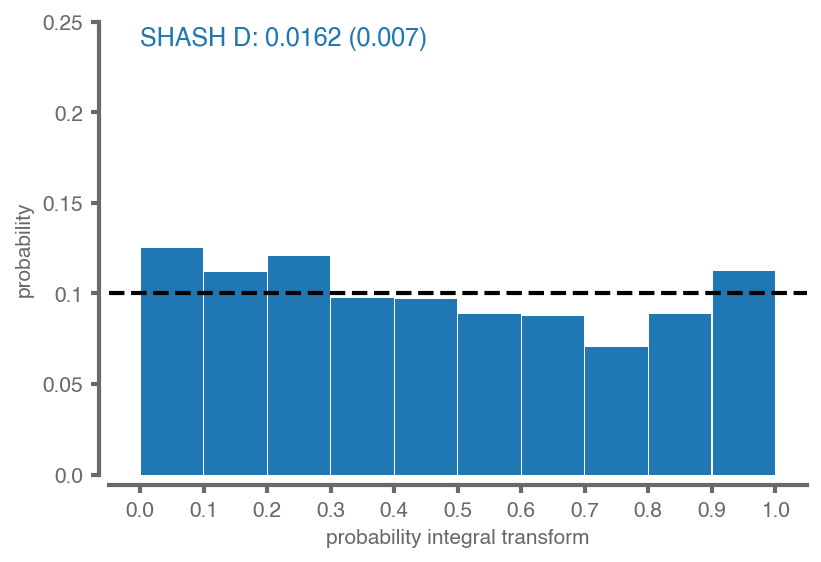

In [13]:
imp.reload(plots)
fig, ax = plt.subplots(1,1)
# plots.plot_pits(ax, x_val=x_test, onehot_val=onehot_test,  model_shash = model)
plots.plot_pits(ax, x_val=np.append(x_val,x_test,axis=0), onehot_val=np.append(onehot_val,onehot_test,axis=0),  model_shash = model)
plt.ylim(0,.25)
format_spines(plt.gca())
plots.savefig(FIGURE_DIRECTORY + model_name + '_pit', dpi=savefig_dpi)
plt.show()
# plt.close()

#### 